## Table of content

* [1. Imports](#imports)
* [2. Open File](#open)
* [3. Find Board Books](#board)
* [4. Content Based Recommendation System: based on book description](#recom_desc)
    * [4.1. Clean and Lemmatize Book Description](#clean_desc)
    * [4.2 Recommendation System: based on book description](#function)
* [5. Content Based Recommendation System based on reviews](#reviews)
    * [5.1 Clean and Lemmatize Reviews](#clean_rev)
    * [5.2 Recommendation System: based on book reviews](#function_rev)


In this notebook we built two recommendation systems. The first is for toddler books and the second is for older kids.

## 1. Imports <a class='anchor' id='imports'>

In [582]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import nltk

nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

# nltk.download('averaged_perceptron_tagger')

from nltk.corpus import wordnet
nltk.download('wordnet')

from gensim.parsing.preprocessing import remove_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer

import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot
from gensim.models import KeyedVectors

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\somfl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\somfl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Open File <a class='anchor' id='open'>

In [583]:
path = 'C:\\Users\\somfl\\Documents\\GitHub\\Somayeh_Youssefi\\Book Recomendation System\\data_files\\CleanedBooks.csv'
df = pd.read_csv(path, sep=',')
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

,book_id,isbn,title,description,num_pages,authors,ratings_count,average_rating,image_url,url,similar_books,authors_names,genres,positive_review,negative_review
0,287141,1599150603,The Aeneid for Boys and Girls,"Relates in vigorous prose the tale of Aeneas, ...",162.0,"[{'author_id': '3041852', 'role': ''}]",46.0,4.13,https://s.gr-assets.com/assets/nophoto/book/11...,https://www.goodreads.com/book/show/287141.The...,[],Alfred J. Church,"{'history, historical fiction, biography': 9, ...","Once again, my kids loved this book about anci...",NaN
1,6066812,1934876569,All's Fairy in Love and War (Avalon: Web of Ma...,"To Kara's astonishment, she discovers that a p...",216.0,"[{'author_id': '19158', 'role': ''}]",98.0,4.22,https://images.gr-assets.com/books/1316637798m...,https://www.goodreads.com/book/show/6066812-al...,"['948696', '439885', '274955', '12978730', '37...",['Rachel Roberts'],"{'fantasy, paranormal': 32, 'young-adult': 8, ...",NaN,"This was a really cute book, though to be hone..."
2,89378,0590417010,Dog Heaven,In Newbery Medalist Cynthia Rylant's classic b...,40.0,"[{'author_id': '5411', 'role': ''}]",1331.0,4.43,https://images.gr-assets.com/books/1360057676m...,https://www.goodreads.com/book/show/89378.Dog_...,"['834493', '452189', '140185', '1897316', '218...",['Cynthia Rylant'],"{'children': 109, 'fiction': 13, 'non-fiction'...","Really cute, sweet, and charming.,This beautif...",I probably would have liked this book more if ...
3,1698376,1416904999,What Do You Do?,WHAT DO YOU DO?\nA hen lays eggs...\nA cow giv...,24.0,"[{'author_id': '169159', 'role': ''}]",23.0,3.57,https://s.gr-assets.com/assets/nophoto/book/11...,https://www.goodreads.com/book/show/1698376.Wh...,[],['Mandy Stanley'],{'children': 6},NaN,Colourful. Fun to read. My daughter enjoys thi...
4,3631900,0884482987,Amadi's Snowman: A Story of Reading,When Amadi disobeys his mother and runs off to...,32.0,"[{'author_id': '1540277', 'role': ''}, {'autho...",44.0,3.89,https://images.gr-assets.com/books/1300370678m...,https://www.goodreads.com/book/show/3631900-am...,[],"['Katia Novet Saint-Lot', 'Dimitrea Tokunbo']","{'fiction': 6, 'children': 8, 'young-adult': 1}",My nine-year-old son and I enjoyed this book a...,"This is an enjoyable book, and Amadi is an eng..."


In [603]:
df.dropna(subset=['description'], axis=0, inplace = True)
df = df.reset_index().drop(columns='index')

In [605]:
df.isna().sum()

book_id                0
isbn                4542
title                  0
description            0
num_pages              0
authors                0
ratings_count          0
average_rating         0
image_url              0
url                    0
similar_books          0
authors_names          0
genres                 0
positive_review    10638
negative_review    22768
dtype: int64

In [661]:
df.drop_duplicates(subset=['title'], keep='first', inplace = True)
df = df.reset_index().drop(columns='index')

## 3. Book Recommendation System for Toddlers <a class='anchor' id='recom_desc'>

### 3.1.  Find Board Books <a class='anchor' id='board'>

In [680]:
# Let's see how many board books we have:
board_book_list = []
for i in range(len(df)):
    text = df.loc[i, 'description'].lower()
    if ((re.search('board book', text)) or (re.search('sensory', text)) or (re.search('touch', text)) or (re.search('flap',text))
    or (re.search('new reader', text)) or (re.search('teach color', text)) or (re.search('teach numbers', text)) 
    or (re.search('teach color', text)) or (re.search('infant', text)) or (re.search('toddler', text)) or (re.search('baby', text))
    or (re.search('illustration', text) and re.search('toddler', text)) or (re.search('picture', text) and re.search('toddler', text))
    or (re.search('illustration', text) and re.search('baby', text)) or (re.search('picture', text) and re.search('toddler', text))
       or (re.search('sesame street', text)) or (re.search('dr. seuss', text))):
        board_book_list.append(df.loc[i,'book_id'])

In [691]:
mask = df['book_id'].isin(board_book_list)
df_board_book = df[mask]
df_board_book = df_board_book.reset_index()


In [692]:
df_board_book.shape

(4937, 16)

In [693]:
df_board_book.isna().sum()

index                 0
book_id               0
isbn                238
title                 0
description           0
num_pages             0
authors               0
ratings_count         0
average_rating        0
image_url             0
url                   0
similar_books         0
authors_names         0
genres                0
positive_review     797
negative_review    2002
dtype: int64

### 3.2.  Clean and Lemmatize Book Description <a class='anchor' id='clean_desc'>

In [694]:
# Let's define a function to clean the text

def clean_function (text):

    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # remove non-ASCII characheters
    
    text = "".join(i for i in text if  ord(i)<128)
    
    # change to lower case
    text = text.lower()

    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    contractions = { 
    "ain't": "am not","aint": "am not",
    "aren't": "are not","arent": "are not",
    "can't": "cannot","cant": "cannot",
    "can't've": "cannot have","cant've": "cannot have",
    "'cause": "because",
    "could've": "could have","couldve": "could have",
    "couldn't": "could not","couldnt": "could not",
    "couldn't've": "could not have","couldnt've": "could not have",
    "didn't": "did not","didnt": "did not",
    "doesn't": "does not","doesnt": "does not",
    "don't": "do not","dont": "do not",
    "hadn't": "had not","hadnt": "had not",
    "hadn't've": "had not have","hadnt've": "had not have",
    "hasn't": "has not","hasnt": "has not",
    "haven't": "have not","havent": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would","id": "i would",
    "i'll": "i will",
    "i'm": "i am","im": "i am",
    "i've": "i have","ive": "i have",
    "isn't": "is not","isnt": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not","mustnt": "must not",
    "needn't": "need not",
    "oughtn't": "ought not",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is","thats": "that is",
    "there'd": "there had",
    "there's": "there is","theres": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "where'd": "where did",
    "where's": "where is",
    "who'll": "who will",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are"
    }  

    text = word_tokenize(text)
    # Replace contractions with their longer forms 
    new_text = []
    for word in text:
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
    text = " ".join(new_text)
        
    # Removing english stopwords 
    text = remove_stopwords(text)

    return text

In [695]:
# Lemmatize and stemming

def preprocess(text):
    text = word_tokenize(text)
    result = []
    for word in text:

        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        lemm = nltk.stem.WordNetLemmatizer().lemmatize(word, tag_dict.get(tag, wordnet.NOUN))
        
        stemmer = SnowballStemmer('english')
        stemm = stemmer.stem(lemm)
        result.append(stemm)
    result = " ".join(result)
    return result
        

In [696]:
# Let's clean and lemmatize description

df_board_book['clean_desc'] = df_board_book['description'].apply(clean_function)
df_board_book['lem_clean_desc'] = df_board_book['clean_desc'].apply(preprocess)

### 3.3.   Recommendation System for toddlers: based on book description <a class='anchor' id='function'>

In [700]:
# Function for recommending books based on Book description. It takes book title as input:
def recomm_title(book_title):

    indx = pd.Series(df_board_book.index, index = df_board_book['title'])

    #Converting the book discription into vectors
    tfModel = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), min_df = 1, stop_words='english')
    tfidf_vector = tfModel.fit_transform(df_board_book['lem_clean_desc'])
    
    # Estimate the similarity of book description based on Cosine Similarity
    similarity_matrix = cosine_similarity(tfidf_vector, tfidf_vector)
    
    # Get the index corresponding to original_title
       
    idx = indx[book_title]# Get the pairwsie similarity scores 
    similar_books = sorted(list(enumerate(similarity_matrix[idx])), key=lambda x: x[1], reverse=True)
    Top_five_similar_books = similar_books[1:6]# Book indicies
    book_indices = [i[0] for i in Top_five_similar_books]
   
    # Top 10 book recommendation
    recommendation = df_board_book[['title', 'authors_names']].iloc[book_indices]
       
    # It reads the top 5 recommended book urls and print the images
    

    return recommendation

In [701]:
recomm_title('Baby Sea Otter')

,title,authors_names
2475,Otters Love to Play,"['Jonathan London', 'Meilo So']"
1476,"Good Night, Little Sea Otter","['Janet Halfmann', 'Wish Williams']"
1872,Baby Otter,"['Ginjer L. Clarke', 'Robbin Cuddy']"
2326,A Lot of Otters,['Barbara Helen Berger']
4263,Otter Loves Halloween,['Sam Garton']


## 5. Book Recommendation System for Teenagers based on book reviews <a class='anchor' id='reviews'>

Let's find the books for kids. We will drop the toddlers' books from datafarme. We then drop the books with empty positive reviews. Then we look at the length of reviews and only keep those with words between 1000 to 5000. There are some words with so many reviews such as Harry Potter series, which will affect the topic extraction.

Non- will be used to etract topics. This methods outperforms LDA.

### 5.1. Find Teenage Books

In [630]:
# df_kid_book
non_kid_list = board_book_list 
mask = ~df['book_id'].isin(set(non_kid_list))
df_kid_book = df[mask]
df_kid_book = df_kid_book.reset_index()
df_kid_book.drop(['index'], axis=1, inplace=True)

df_kid_book.shape

(52688, 15)

In [632]:
df_kid_book.isna().sum()

book_id                0
isbn                4214
title                  0
description            0
num_pages              0
authors                0
ratings_count          0
average_rating         0
image_url              0
url                    0
similar_books          0
authors_names          0
genres                 0
positive_review     9639
negative_review    20391
dtype: int64

### 5.2. Drop Books with No Positive Reviews

In [634]:
df_kid_book.dropna(subset=['positive_review'], axis=0, inplace=True)

In [635]:
## let's check the length of reviews
def splitt(text):
    text = text.split()
    return len(text)

df_kid_book['review_length'] = df_kid_book['positive_review'].apply(splitt)

<AxesSubplot:ylabel='Frequency'>

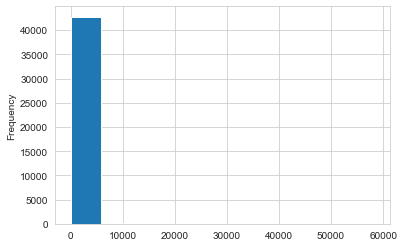

In [636]:
df_kid_book['review_length'].plot.hist(bins=10)

<AxesSubplot:ylabel='Frequency'>

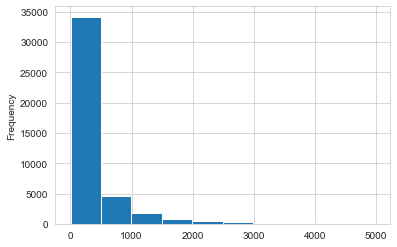

In [637]:
df_kid_book.loc[df_kid_book['review_length']<5000, 'review_length'].plot.hist(bins=10)

In [639]:
long_review_list = df_kid_book.loc[(df_kid_book['review_length']>1000) & (df_kid_book['review_length']<5000), 'book_id']
mask = df_kid_book['book_id'].isin(long_review_list)
df_kid_book = df_kid_book[mask]
df_kid_book = df_kid_book.reset_index()
df_kid_book.drop(['index'], axis=1, inplace=True)
df_kid_book.shape

(3925, 16)

## 5.3. Topic Extraction

### 5.3.1.  Find Vey Common Words from Reviews

In [640]:
tfModel = TfidfVectorizer(stop_words='english', analyzer='word', ngram_range=(1, 1), min_df = 100)

data_cv = tfModel.fit_transform(df_kid_book['positive_review'])
data_dtm = pd.DataFrame(data_cv.toarray(), columns=tfModel.get_feature_names())
data_dtm.index = df_kid_book.index
data_dtm_copy = data_dtm
word_df = pd.DataFrame(data_dtm.sum())
word_df = word_df.sort_values(by = 0, ascending = False)
print(word_df.shape)

(3176, 1)


In [642]:
word_df.head(20)

,0
book,710.140758
story,340.885852
read,311.436500
children,198.258121
illustrations,181.525774
like,176.194188
love,169.438790
books,167.185898
great,160.243634
series,149.773173


In [643]:
custom_stop_words = []
custom_stop_words = word_df[0:40].index 
custom_stop_words = list(custom_stop_words)
custom_stop_words =  custom_stop_words + ['families', 'years', 'reader', 'illustration', 'picture']

def custom_clean(text):
    text = text.split()
    stops = custom_stop_words 
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

### 5.3.2. Clean the Reviews

In [644]:

df_kid_book['first_round'] = df_kid_book['positive_review'].apply(clean_function)
df_kid_book['second_round'] = df_kid_book['first_round'].apply(custom_clean)


### 5.3.3. Extract Verbs from Reviews

In [646]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))        
        
def preprocess(text):
    text = word_tokenize(text)
    result = []
    for word in text:

        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        lemm = nltk.stem.WordNetLemmatizer().lemmatize(word, tag_dict.get(tag, wordnet.NOUN))
        
        stemmer = SnowballStemmer('english')
        stemm = stemmer.stem(lemm)
        result.append(stemm)
    result = " ".join(result)
    return result

def lemmatize_stemming(text):
    stemmer = SnowballStemmer('english')
    return stemmer.stem(nltk.stem.WordNetLemmatizer().lemmatize(text, pos='v'))
        
# Let's create a function to pull out nouns from a string of text
def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

def adj(text):
    '''Given a string of text, tokenize the text and pull out only the  adjectives.'''
    is_adj = lambda pos: pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    adj = [word for (word, pos) in pos_tag(tokenized) if is_adj(pos)] 
    return ' '.join(adj)

def review_process(text):
    text = word_tokenize(text)
    stemmer = SnowballStemmer('english')
    result = []
    for word in text:
        stemm = stemmer.stem(nltk.stem.WordNetLemmatizer().lemmatize(word, pos='v'))
        result.append(stemm)
    result = " ".join(result)
    return result


def nouns_v(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and verbs.'''
    is_noun_v = lambda pos: pos[:2] == 'NN' or pos[:2] == 'VB'
    tokenized = word_tokenize(text)
    nouns_v = [word for (word, pos) in pos_tag(tokenized) if is_noun_v(pos)] 
    return ' '.join(nouns_v)

def verbs(text):
    '''Given a string of text, tokenize the text and pull out only the the verbs.'''
    is_verb = lambda pos: pos[:2] == 'VB'
    tokenized = word_tokenize(text)
    verbs = [word for (word, pos) in pos_tag(tokenized) if is_verb(pos)] 
    return ' '.join(verbs)

In [647]:
df_kid_book['review_topic'] = df_kid_book['second_round'].apply(review_process)

In [654]:
data_verbs = pd.DataFrame(df_kid_book['second_round'].apply(verbs))

tv_verb = TfidfVectorizer(ngram_range = (1,1), min_df = 1)
data_tv_verb = tv_verb.fit_transform(data_verbs['second_round'])

nmf_model = NMF(15)
doc_topic = nmf_model.fit_transform(data_tv_verb)

components_df = pd.DataFrame(nmf_model.components_, columns=tv_verb.get_feature_names())

for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(15))
    print('\n')
                                                


For topic 1 the words with the highest value are:
wants      1.091823
gets       0.703424
want       0.547024
makes      0.453737
goes       0.450247
going      0.441441
comes      0.422018
loves      0.402018
trying     0.385610
getting    0.383251
finds      0.347558
takes      0.310140
play       0.294451
having     0.286352
come       0.285815
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
rhyming        2.161246
rhymes         0.235384
rhyme          0.205882
sing           0.134738
bed            0.124288
illustrated    0.119661
bright         0.116831
makes          0.109859
loves          0.104650
engaging       0.089836
received       0.086403
got            0.084991
enjoyed        0.084684
sounds         0.082127
rhymed         0.081130
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
rose          1.992203
booke         0.079514
devoted       0.073576
baking        0.056572
wilder        0.048246
talking       0.048092


In [732]:
doc_topics = pd.DataFrame(doc_topic, index = df_kid_book.index)
doc_topics['topic_number'] = doc_topics.idxmax(axis=1)


### 5.4. Give Topics Labels and Classify Books

In [740]:
labels = ['1: planning', '2: rhyming_and_singing', '3: love_and_family', '4: inspirational', '5: memories', '6: history', 
          '7: animals', '8: bullying', '9: poetry', '10: fiction ', '11: missing_loved_ones', '12: teaching',
          '13: Christmas_tories', '14: animals_and_nature' ,'15: teach_maths']

In [757]:
topics_dic = {}
for i in range(len(labels)):
    topics_dic[i] = labels[i]
for i in range(len(doc_topics)):
    x = doc_topics.loc[i, 'topic_number']
    doc_topics.loc[i, 'label'] = topics_dic[x]
topics_book = doc_topics['label']
kid_books = df_kid_book.merge(topics_book, left_index=True, right_index=True)

In [762]:
kid_books.loc[kid_books['label']=='15: teach_maths'].head(3)

,book_id,isbn,title,description,num_pages,authors,ratings_count,average_rating,image_url,url,similar_books,authors_names,genres,positive_review,negative_review,review_length,first_round,second_round,review_topic,label
3,1076040,069001287X,Anno's Counting Book,"Every child is a natural mathematician, accord...",28.0,"[{'author_id': '72077', 'role': ''}]",551.0,4.06,https://s.gr-assets.com/assets/nophoto/book/11...,https://www.goodreads.com/book/show/1076040.An...,"['289881', '6516912', '1873420', '282631', '21...",['Mitsumasa Anno'],"{'children': 96, 'non-fiction': 6, 'fiction': 4}",Genre: Counting \n Summary: A wordless picture...,Awesome description and intro. to math for you...,1368,genre counting summary wordless picture book d...,genre counting summary wordless depicts notion...,genr count summari wordless depict notion coun...,15: teach_maths
65,34740357,0802854923,Plume,"In this lovely book, young readers are introdu...",42.0,"[{'author_id': '13832085', 'role': ''}]",123.0,4.17,https://images.gr-assets.com/books/1494501837m...,https://www.goodreads.com/book/show/34740357-p...,[],['Isabelle Simler'],"{'children': 31, 'fiction': 1, 'non-fiction': 1}",ADORABLE. As a proud owner of a mini black pan...,NaN,1466,adorable proud owner mini black panther enjoys...,adorable proud owner mini black panther enjoys...,ador proud owner mini black panther enjoy feat...,15: teach_maths
262,16056793,0745964141,My Very First Noah's Ark Playtime: Activity Bo...,An activity book with stickers to keep childre...,16.0,"[{'author_id': '177078', 'role': ''}, {'author...",18.0,4.44,https://images.gr-assets.com/books/1349813698m...,https://www.goodreads.com/book/show/16056793-m...,[],"['Lois Rock', 'Alex Ayliffe']",{'children': 4},My Very First Noah's Ark Playtime is the third...,NaN,1190,noah s ark playtime sticker book line ve enjoy...,noah s ark playtime sticker line ve enjoyed op...,noah s ark playtim sticker line ve enjoy opini...,15: teach_maths


In [763]:
kid_books.loc[kid_books['label']=='14: animals_and_nature'].head(3)

,book_id,isbn,title,description,num_pages,authors,ratings_count,average_rating,image_url,url,similar_books,authors_names,genres,positive_review,negative_review,review_length,first_round,second_round,review_topic,label
113,12394114,0062081950,Penny and Her Song,"When Penny comes home from school, she is read...",32.0,"[{'author_id': '193', 'role': ''}]",1119.0,3.80,https://images.gr-assets.com/books/1325397916m...,https://www.goodreads.com/book/show/12394114-p...,"['12909138', '12177920', '11867718', '11737017...",['Kevin Henkes'],"{'children': 116, 'fiction': 18, 'fantasy, par...","http://librarianosnark.blogspot.com/2...,Be pr...",Penny has a special song she wants to sing to ...,1607,young children delight kevin henkes book begin...,delight kevin henkes beginning relate penny wa...,delight kevin henk begin relat penni want pare...,14: animals_and_nature
127,9327107,0763650552,Tell Me the Day Backwards,"In this delightful bedtime story, a young bear...",40.0,"[{'author_id': '895230', 'role': ''}, {'author...",482.0,3.83,https://images.gr-assets.com/books/1320561969m...,https://www.goodreads.com/book/show/9327107-te...,"['10427002', '8739824', '11532312', '10326007'...","['Albert Lamb', 'David McPhail']","{'children': 64, 'fiction': 7}",Tell Me the Day Backwards by Albert Lamb is is...,A baby bear is encouraged by his mother to rem...,1422,tell day backwards albert lamb young bear cub ...,tell day backwards albert lamb bear cub gettin...,tell day backward albert lamb bear cub get rea...,14: animals_and_nature
164,233714,0140309578,Pippi Longstocking,The beloved story of a spunky young girl and h...,160.0,"[{'author_id': '410653', 'role': ''}, {'author...",786.0,4.11,https://images.gr-assets.com/books/1309287432m...,https://www.goodreads.com/book/show/233714.Pip...,"['1306827', '1148052', '224538', '157551', '46...","['Astrid Lindgren', 'Louis S. Glanzman', 'Flor...","{'children': 4702, 'fiction': 923, 'young-adul...",A rather odd combination of circumstances have...,Clearly I don't understand the magic of Pippi ...,1369,odd combination circumstances led read book ha...,odd combination circumstances led hand appears...,odd combin circumst lead hand appear norwegian...,14: animals_and_nature


## Summary <a class='anchor' id='summary'>


In [766]:

dff = df_kid_book

dff['desc_clean'] = dff['description'].apply(clean_function)

data_verbs_2 = pd.DataFrame(dff['desc_clean'].apply(verbs))

tv_verb_2 = TfidfVectorizer(ngram_range = (1,1), min_df = 1)
data_tv_verb_2 = tv_verb_2.fit_transform(data_verbs_2['desc_clean'])

nmf_model_2 = NMF(15)
doc_topic_2 = nmf_model_2.fit_transform(data_tv_verb_2)

components_dff = pd.DataFrame(nmf_model_2.components_, columns=tv_verb_2.get_feature_names())

for topic in range(components_dff.shape[0]):
    tmp = components_dff.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(15))
    print('\n')

For topic 1 the words with the highest value are:
read        2.832094
reading     2.488760
charming    0.574067
enjoy       0.390697
ages        0.388909
writing     0.341982
exciting    0.331890
child       0.309774
fun         0.285354
learning    0.279623
says        0.264196
starred     0.253085
won         0.245602
uses        0.243078
includes    0.231399
Name: 0, dtype: float64


For topic 2 the words with the highest value are:
wants        1.892822
want         0.247765
play         0.224065
friend       0.121499
playing      0.097472
won          0.095287
discovers    0.090067
loves        0.088348
trying       0.083941
looks        0.079470
decides      0.078849
sleep        0.077637
says         0.077280
arrives      0.070360
let          0.065604
Name: 1, dtype: float64


For topic 3 the words with the highest value are:
going         1.903294
getting       0.232672
said          0.159028
end           0.156003
got           0.144125
run           0.118044
save          0

In [ ]:
data_verbs_2 = pd.DataFrame(df_kid_book['second_round'].apply(verbs))

tv_verb = TfidfVectorizer(ngram_range = (1,1), min_df = 1)
data_tv_verb = tv_verb.fit_transform(data_verbs['second_round'])

nmf_model = NMF(15)
doc_topic = nmf_model.fit_transform(data_tv_verb)

components_df = pd.DataFrame(nmf_model.components_, columns=tv_verb.get_feature_names())

for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic+1} the words with the highest value are:')
    print(tmp.nlargest(15))
    print('\n')